# Máquinas de Soporte Vectorial (SVM): Teoría y Práctica

## 1. Introducción: SVM vs Regresión Logística

Las Máquinas de Soporte Vectorial (SVM) buscan el **hiperplano de máximo margen** que separa las clases, mientras que la Regresión Logística busca una frontera basada en probabilidades.

Aunque en problemas linealmente separables ambos pueden dar resultados similares, su fundamento matemático es distinto.

* **Regresión Logística:** Minimiza el error de probabilidad.
* **SVM:** Maximiza la distancia geométrica entre clases (Vectores de Soporte).

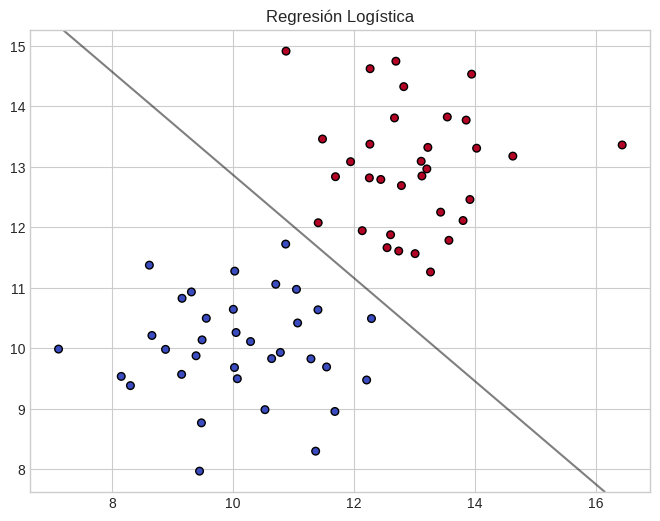

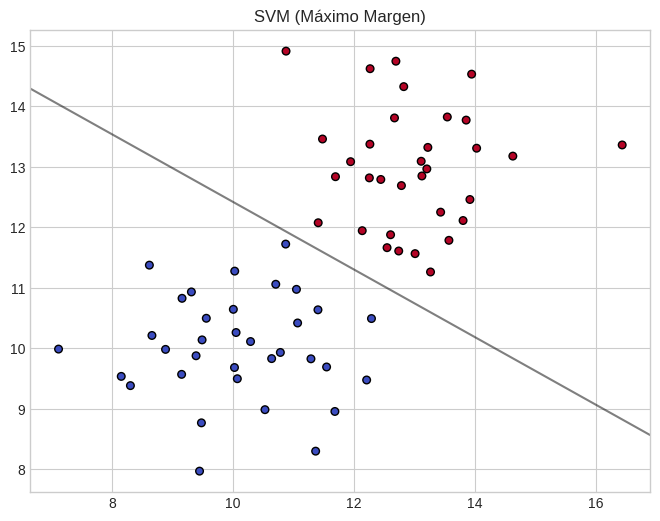

Accuracy LogReg: 0.9697
Accuracy SVM:    0.9697


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.datasets import make_blobs, make_circles

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Generación de datos linealmente separables
X, y = make_blobs(n_samples=100, centers=[[10,10], [13,13]], random_state=40)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

def plot_classifier(X, y, clf=None, title="Clasificador"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    
    if clf:
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        
        # Obtener decisión
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(xy).reshape(XX.shape)
            levels = [0]
        else:
            Z = clf.predict_proba(xy)[:, 1].reshape(XX.shape)
            levels = [0.5]
            
        ax.contour(XX, YY, Z, colors='k', levels=levels, alpha=0.5, linestyles=['-'])
        
    plt.title(title)
    plt.show()

# 2. Comparación
clf_log = LogisticRegression().fit(X_train, y_train)
clf_svm = SVC(kernel="linear").fit(X_train, y_train)

plot_classifier(X_train, y_train, clf_log, title="Regresión Logística")
plot_classifier(X_train, y_train, clf_svm, title="SVM (Máximo Margen)")

print(f"Accuracy LogReg: {accuracy_score(y_test, clf_log.predict(X_test)):.4f}")
print(f"Accuracy SVM:    {accuracy_score(y_test, clf_svm.predict(X_test)):.4f}")

## 2. El Truco del Kernel (Datos No Lineales)

Cuando los datos no se pueden separar con una recta (ej. círculos concéntricos), la SVM lineal falla.
El **Kernel Trick** permite proyectar los datos a una dimensión superior para separarlos.

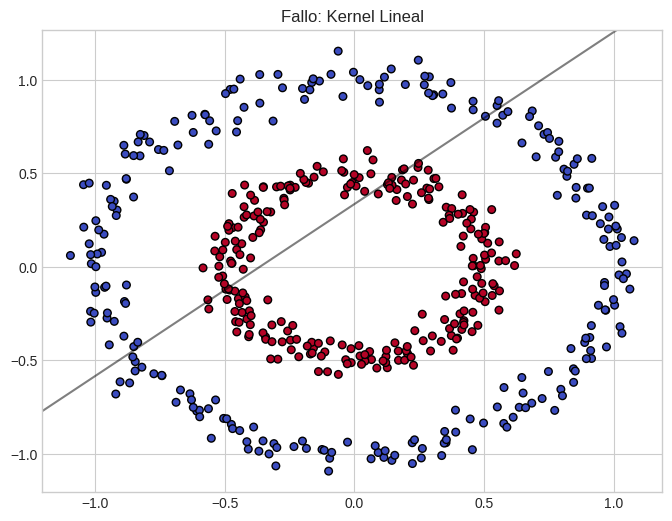

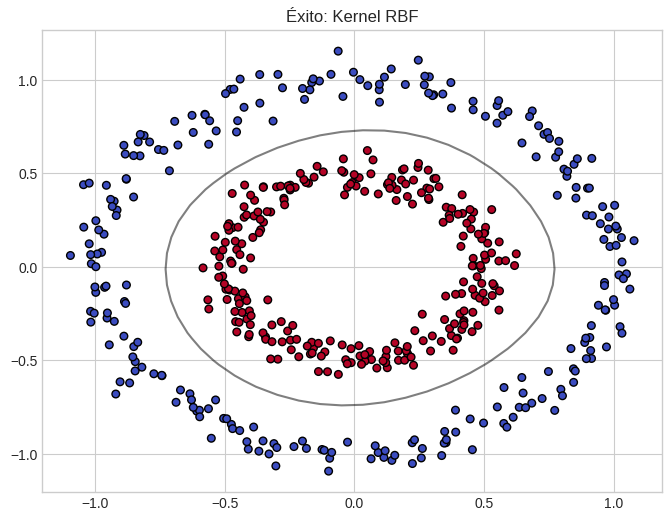

In [2]:
# Generar datos no lineales
X_circle, y_circle = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=42)

# Falla del Kernel Lineal
clf_lin = SVC(kernel="linear").fit(X_circle, y_circle)
plot_classifier(X_circle, y_circle, clf_lin, title="Fallo: Kernel Lineal")

# Éxito del Kernel RBF
clf_rbf = SVC(kernel="rbf", C=1.0).fit(X_circle, y_circle)
plot_classifier(X_circle, y_circle, clf_rbf, title="Éxito: Kernel RBF")

## 3. Actividad: Clasificación Multiclase (Horse Colic)

Usaremos el dataset *Horse Colic* para predecir el estado del caballo (Vivo, Muerto, Sacrificado).
Como SVM es binario, usaremos la estrategia **One-vs-One (OVO)**.

### 3.1 Carga y Limpieza

In [4]:
def get_data(path):
    try:
        # Cargar datos, reemplazando '?' con 0
        data = pd.read_csv(path, sep=r'\s+', header=None, na_values='?', engine='python')
        data.fillna(0, inplace=True)
        
        # Etiqueta en columna 22
        label = data[22].astype(int)
        
        # Features (quitar target y datos extra)
        features = data.drop(columns=range(22, 28)).astype(float)
        
        # Normalización (Vital para SVM)
        features = (features - features.min()) / (features.max() - features.min())
        features.fillna(0, inplace=True)
        
        return features, label
    except FileNotFoundError:
        print("Datos no encontrados. Usando datos sintéticos.")
        return make_blobs(n_samples=300, centers=3, n_features=22, random_state=1)

X_train, y_train = get_data("../data/horse-colic.data")
X_test, y_test = get_data("../data/horse-colic.test")

### 3.2 Experimentación con Parámetros

Probamos diferentes valores de regularización `C`.

In [5]:
# Configuración 1: C=1.0
svm_1 = SVC(kernel="linear", C=1.0, decision_function_shape="ovo")
svm_1.fit(X_train, y_train)
pred_1 = svm_1.predict(X_test)

print(f"--- SVM (C=1.0) ---")
print(f"Accuracy: {accuracy_score(y_test, pred_1)*100:.2f}%")
print(f"F1 Score: {f1_score(y_test, pred_1, average='weighted')*100:.2f}%")

# Configuración 2: C=0.1 (Margen más suave)
svm_2 = SVC(kernel="linear", C=0.1, decision_function_shape="ovo")
svm_2.fit(X_train, y_train)
pred_2 = svm_2.predict(X_test)

print(f"\n--- SVM (C=0.1) ---")
print(f"Accuracy: {accuracy_score(y_test, pred_2)*100:.2f}%")
print(f"F1 Score: {f1_score(y_test, pred_2, average='weighted')*100:.2f}%")

--- SVM (C=1.0) ---
Accuracy: 67.65%
F1 Score: 66.31%

--- SVM (C=0.1) ---
Accuracy: 70.59%
F1 Score: 62.78%
